In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tts

In [2]:
sample_submission = pd.read_csv("/kaggle/input/ieee-fraud-detection/sample_submission.csv")
train_identity= pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")
train_transaction= pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")

In [3]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [7]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

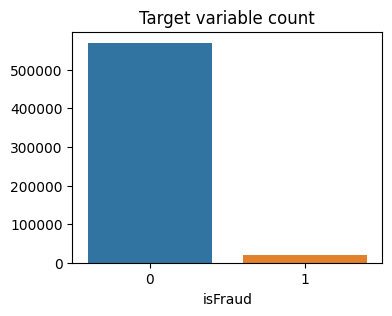

In [8]:
plt.figure(figsize=(4,3))
my_palette = ["#1f77b4", "#ff7f0e"]  
x = train_transaction['isFraud'].value_counts()  
sns.barplot(x=x.index, y=x.values, palette=my_palette)  
plt.title('Target variable count') 
plt.show()  # Display the plot


In [9]:
df =train_transaction.merge(train_identity,how='left',left_index=True,right_index=True)
print('Train shape',df.shape)

Train shape (590540, 435)


In [10]:
df.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [11]:
x = df.drop("isFraud", axis=1) 
y = df[["isFraud"]]

In [12]:
x.head()

,TransactionID_x,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [13]:
y.head()

,isFraud
0,0
1,0
2,0
3,0
4,0


<Axes: title={'center': 'Count (target)'}, xlabel='target'>

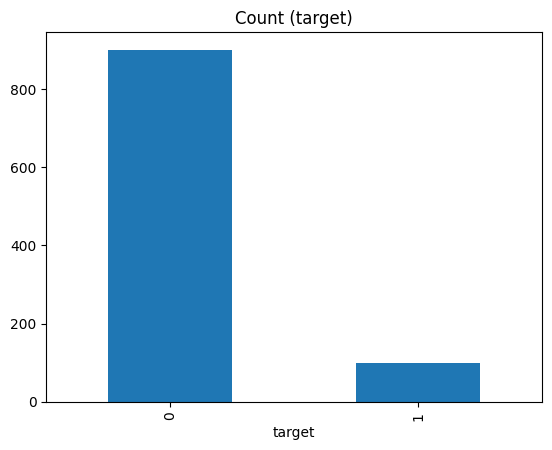

In [14]:
from sklearn.datasets import make_classification

x, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=1000, random_state=10
)

df = pd.DataFrame(x)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)')

In [15]:
x

array([[ 0.60013068, -1.42766402, -0.8128431 , ..., -0.55302378,
         0.14876985, -1.24795877],
       [ 0.25364115, -1.45638734, -0.52259796, ...,  1.69409346,
        -0.24969905,  0.27085707],
       [ 0.18225579, -1.27960188,  0.6780773 , ..., -0.81115113,
        -0.28733609, -1.23417595],
       ...,
       [-1.47024551,  1.44291998, -0.61025173, ..., -0.80856535,
         0.92899574, -0.98753905],
       [ 1.16080297,  1.07930132, -0.10917057, ..., -2.58494382,
        -1.74326156, -0.54876536],
       [-0.29874435, -1.48144343, -0.34051766, ..., -0.17772046,
        -0.13834763, -1.10924765]])

In [16]:
x.shape

(1000, 20)

In [17]:
def logistic(x,y):
    X_train,X_test,y_train,y_test=tts(x,y,test_size=.2,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob[:,1],y_test)

In [18]:
prob,y_test=logistic(x,y)

In [19]:
def plot_pre_curve(y_test,prob):
    precision, recall, thresholds = precision_recall_curve(y_test, prob)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

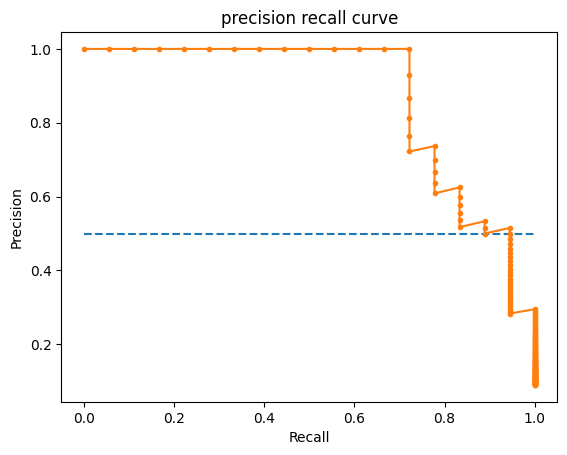

In [20]:
plot_pre_curve(y_test,prob)

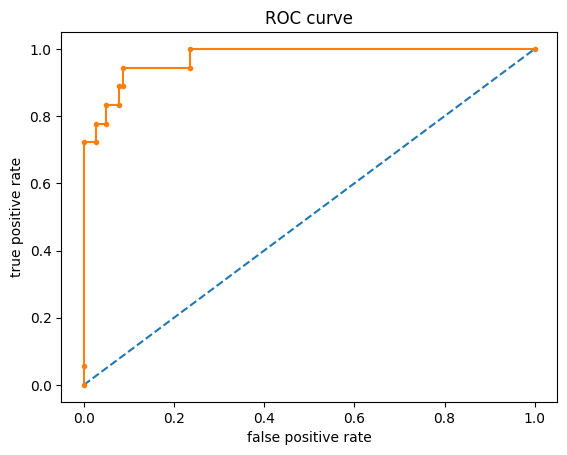

In [21]:
plot_roc(y_test,prob)

**Oversampling**

In [22]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_re, y_re = smote.fit_resample(x, y)

In [23]:
x_re.shape

(1800, 20)

In [24]:
y_re.shape

(1800,)

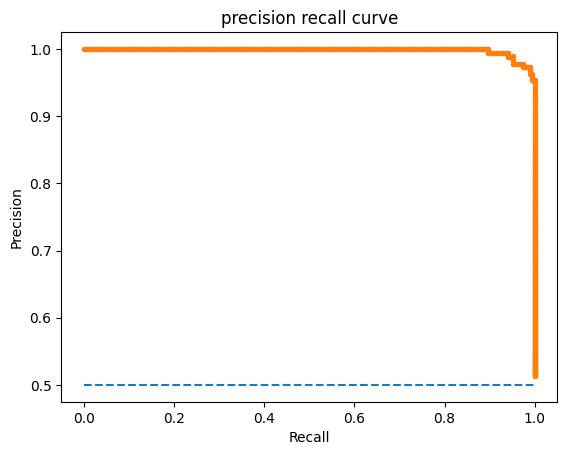

In [25]:
prob,y_test=logistic(x_re,y_re)
plot_pre_curve(y_test,prob)

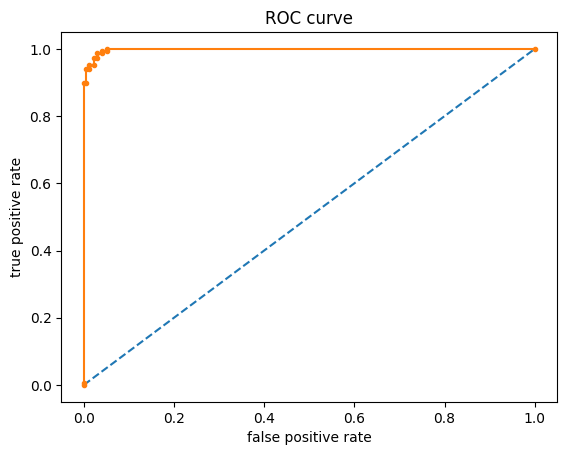

In [26]:
plot_roc(y_test,prob)

**Imbalance**

In [27]:
from imblearn.under_sampling import NearMiss
NearMiss_obj = NearMiss()
new_x , new_y = NearMiss_obj.fit_resample(x,y)

In [28]:
new_x.shape

(200, 20)

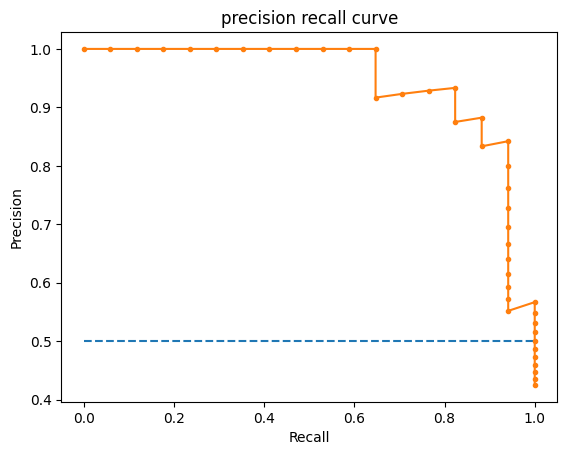

In [29]:
prob,y_test=logistic(new_x,new_y)
plot_pre_curve(y_test,prob)

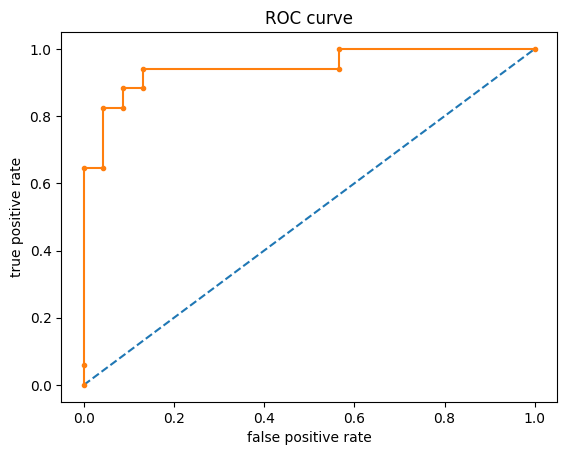

In [30]:
plot_roc(y_test,prob)

**Applying PCA**

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
x_pca = pca.fit_transform(x)

In [32]:
x_pca.shape

(1000, 5)

In [33]:
x_pca

array([[ 0.22242199, -0.61238349, -0.13947361, -0.46051645, -0.22066045],
       [ 0.77716848, -3.18195845,  0.92610379,  0.3388909 , -0.31870708],
       [ 0.75013593, -0.19360637, -0.60334067, -0.19901819, -0.92845458],
       ...,
       [ 1.01814959, -0.24702399, -2.24233398,  0.75632997,  0.95667926],
       [ 0.39767366, -1.96623451,  0.07044696,  0.85491651,  2.55575024],
       [-0.72485924, -1.41714318,  1.52589146, -0.83778171,  1.07894611]])

In [34]:
features = pd.DataFrame(x_pca, columns=['pca1','pca2','pca3','pca4','pca5'])

In [35]:
features

,pca1,pca2,pca3,pca4,pca5
0,0.222422,-0.612383,-0.139474,-0.460516,-0.220660
1,0.777168,-3.181958,0.926104,0.338891,-0.318707
2,0.750136,-0.193606,-0.603341,-0.199018,-0.928455
3,1.594626,-0.840815,-0.822270,-2.074367,1.226542
4,0.268331,-0.003733,-1.735277,-1.011039,3.541094
...,...,...,...,...,...
995,-0.430207,-1.876092,1.415127,-2.011518,0.008409
996,0.312917,-1.060161,-1.408525,-0.188902,0.044393
997,1.018150,-0.247024,-2.242334,0.756330,0.956679
998,0.397674,-1.966235,0.070447,0.854917,2.555750


In [36]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_re, y_re = smote.fit_resample(features, y)

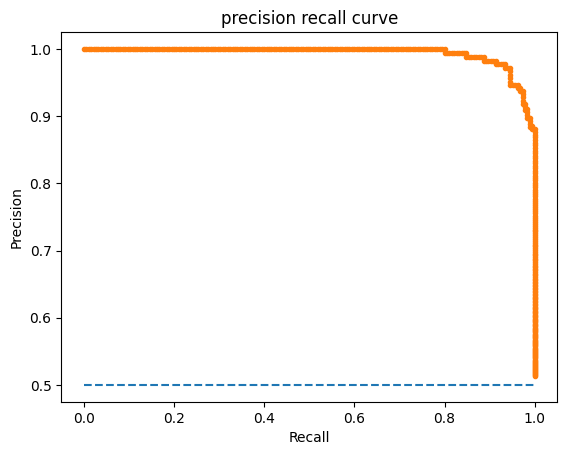

In [37]:
prob,y_test=logistic(x_re,y_re)
plot_pre_curve(y_test,prob)

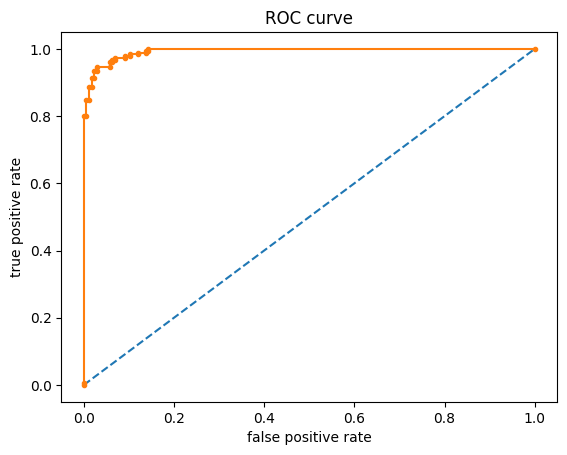

In [38]:
plot_roc(y_test,prob)

# Using cross validation

In [39]:
X_train,X_test,y_train,y_test=tts(x,y,test_size=.2,random_state=1)
lr=LogisticRegression()
lr.fit(X_train,y_train)
prob=lr.predict_proba(X_test)

In [40]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=5, shuffle=True)
result = cross_val_score(lr, x_re, y_re, cv=kfold) 

In [41]:
def plot_pre_curve(y_test,result):
    precision, recall, thresholds = precision_recall_curve(y_test, result)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    
def plot_roc(y_test,result):
    fpr, tpr, thresholds = roc_curve(y_test, result)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

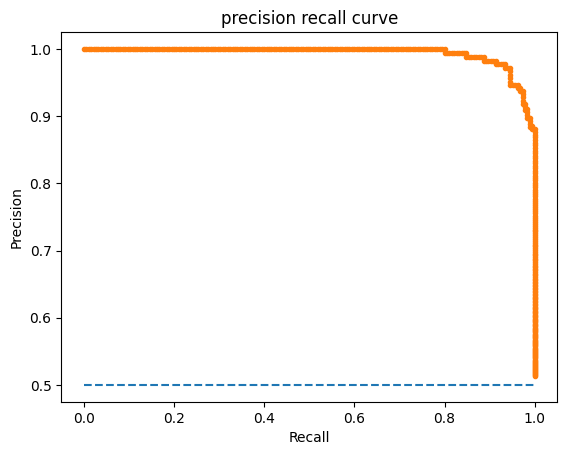

In [42]:
result,y_test=logistic(x_re, y_re)
plot_pre_curve(y_test,result)

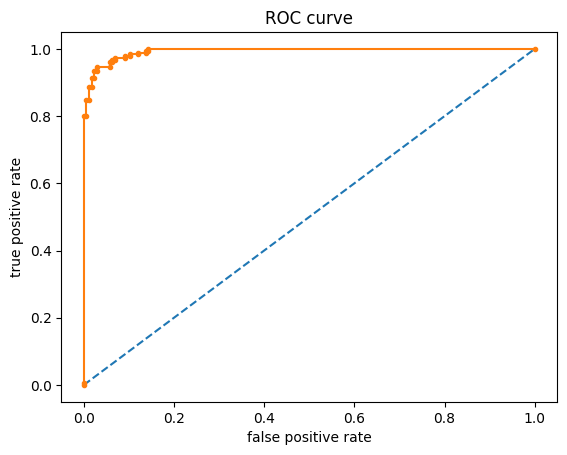

In [43]:
plot_roc(y_test,result)